In [1]:
import sys
import os
from itertools import product
import math
import numpy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.manifold import TSNE, MDS
import umap
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

sys.path.append(os.path.abspath("../sim_metric/dists"))
from scoring import *

In [2]:
def symmetrize(A):
    n = A.shape[0]
    B = A.copy()
    B[np.tril_indices(n)] = B.T[np.tril_indices(n)]
    return B

In [3]:
# Import MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data/',
                                        train=True,
                                        transform=transforms.ToTensor())

# Generate matrix of all train data images
full_train_data = []
for i in range(len(train_dataset)):
    full_train_data.append(train_dataset[i][0].reshape(-1, 28*28))
full_train_data = torch.vstack(full_train_data)

In [4]:
num_data = full_train_data.shape[0]

In [5]:
#widths = np.hstack((10, 50*np.arange(1, 21)))
widths = 100*np.arange(1, 11)
#depths = np.hstack((1, 5*np.arange(1, 6)))
depths = np.arange(1, 11)
seeds = np.arange(1, 5)

num_widths = len(widths)
num_depths = len(depths)
num_seeds = len(seeds)

In [6]:
print(depths)
print(widths)

[ 1  2  3  4  5  6  7  8  9 10]
[ 100  200  300  400  500  600  700  800  900 1000]


In [7]:
filenames = os.listdir("distances/widthdepth/")
distnames = []
for filename in filenames:
    if filename.endswith("npy"):
        distnames.append(filename[:-4])
distnames = np.sort(distnames)

In [8]:
distnames

array(['lin_cka_dist', 'lin_cka_prime_dist', 'mean_cca_e2e',
       'mean_sq_cca_e2e', 'predictor_dist_0.0', 'predictor_dist_0.0001',
       'predictor_dist_0.001', 'predictor_dist_0.01',
       'predictor_dist_0.1', 'predictor_dist_1.0', 'predictor_dist_10.0',
       'predictor_dist_100.0', 'predictor_dist_1000.0',
       'predictor_dist_10000.0', 'predictor_dist_1e-05',
       'predictor_dist_1e-06', 'predictor_dist_1e-07',
       'predictor_dist_1e-08', 'predictor_dist_1e-09',
       'predictor_dist_1e-10', 'predictor_dist_1e-11',
       'predictor_dist_1e-12', 'predictor_dist_1e-13',
       'predictor_dist_1e-14', 'predictor_dist_1e-15',
       'predictor_dist_1e-16', 'predictor_dist_1e-17',
       'predictor_dist_1e-18', 'predictor_dist_1e-19',
       'predictor_dist_1e-20', 'procrustes', 'pwcca_dist_e2e'],
      dtype='<U22')

In [9]:
distnames = np.array(['lin_cka_dist',
             'lin_cka_prime_dist',
             'mean_cca_e2e',
             'mean_sq_cca_e2e',
             'procrustes',
             'pwcca_dist_e2e',
             'predictor_dist_0.0',
             'predictor_dist_1e-20',
             'predictor_dist_1e-19',
             'predictor_dist_1e-18',
             'predictor_dist_1e-17',
             'predictor_dist_1e-16',
             'predictor_dist_1e-15',
             'predictor_dist_1e-14',
             'predictor_dist_1e-13',
             'predictor_dist_1e-12',
             'predictor_dist_1e-11',
             'predictor_dist_1e-10',
             'predictor_dist_1e-09',
             'predictor_dist_1e-08',
             'predictor_dist_1e-07',
             'predictor_dist_1e-06',
             'predictor_dist_1e-05',
             'predictor_dist_0.0001',
             'predictor_dist_0.001',
             'predictor_dist_0.01',
             'predictor_dist_0.1',
             'predictor_dist_1.0',
             'predictor_dist_10.0',
             'predictor_dist_100.0',
             'predictor_dist_1000.0',
             'predictor_dist_10000.0'])

In [10]:
stats = np.load("distances/widthdepth/stats.npz")
model_names = stats["model_names"]
total_models = len(model_names)
dist_pairs_saved = stats["dist_pairs_saved"]

In [11]:
print(np.arange(total_models) - np.sum(dist_pairs_saved, axis=0))
print(np.arange(total_models) - np.flip(np.sum(dist_pairs_saved, axis=1)))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [12]:
model_widths = []
model_depths = []
model_seeds = []
for name in model_names:
    splits = name.split("_")
    model_widths.append(int(splits[0][5:]))
    model_depths.append(int(splits[1][5:]))
    model_seeds.append(int(splits[2][4:]))
model_widths = np.array(model_widths)
model_depths = np.array(model_depths)
model_seeds = np.array(model_seeds)

sorted_inds = np.lexsort((model_widths, model_depths, model_seeds))

In [13]:
print(np.unique(model_widths))
print(np.unique(model_depths))
print(np.unique(model_seeds))

[ 100  200  300  400  500  600  700  800  900 1000]
[ 1  2  3  4  5  6  7  8  9 10]
[1 2 3 4]


In [14]:
model_names[sorted_inds]

array(['width100_depth1_seed1', 'width200_depth1_seed1',
       'width300_depth1_seed1', 'width400_depth1_seed1',
       'width500_depth1_seed1', 'width600_depth1_seed1',
       'width700_depth1_seed1', 'width800_depth1_seed1',
       'width900_depth1_seed1', 'width1000_depth1_seed1',
       'width100_depth2_seed1', 'width200_depth2_seed1',
       'width300_depth2_seed1', 'width400_depth2_seed1',
       'width500_depth2_seed1', 'width600_depth2_seed1',
       'width700_depth2_seed1', 'width800_depth2_seed1',
       'width900_depth2_seed1', 'width1000_depth2_seed1',
       'width100_depth3_seed1', 'width200_depth3_seed1',
       'width300_depth3_seed1', 'width400_depth3_seed1',
       'width500_depth3_seed1', 'width600_depth3_seed1',
       'width700_depth3_seed1', 'width800_depth3_seed1',
       'width900_depth3_seed1', 'width1000_depth3_seed1',
       'width100_depth4_seed1', 'width200_depth4_seed1',
       'width300_depth4_seed1', 'width400_depth4_seed1',
       'width500_depth4_seed

In [15]:
sub_inds = np.where((np.array(model_depths)[sorted_inds] > 0) & (np.array(model_widths)[sorted_inds] > 0))[0]

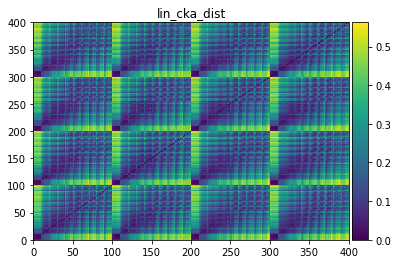

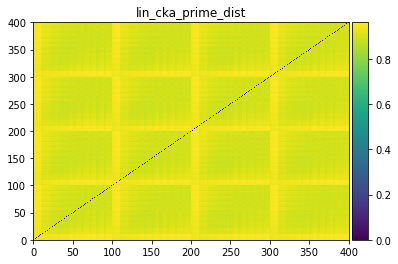

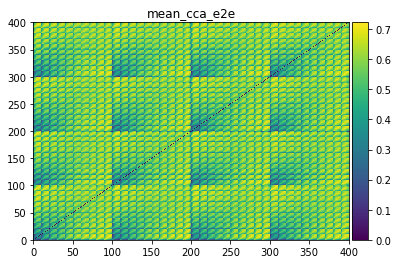

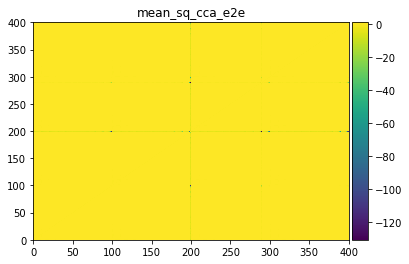

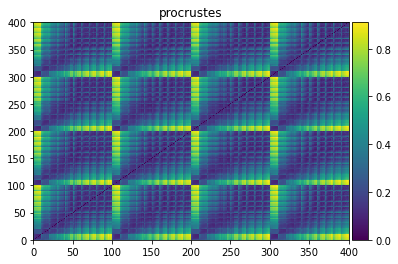

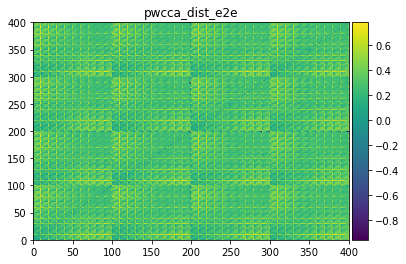

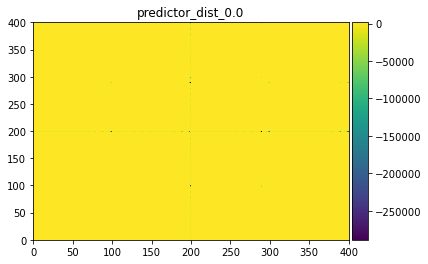

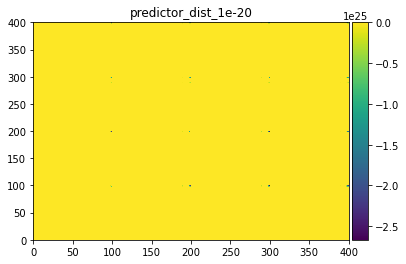

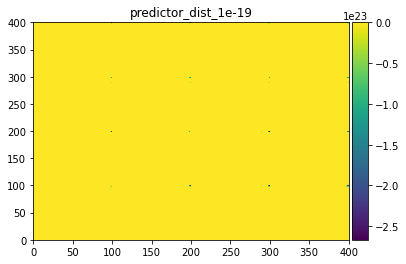

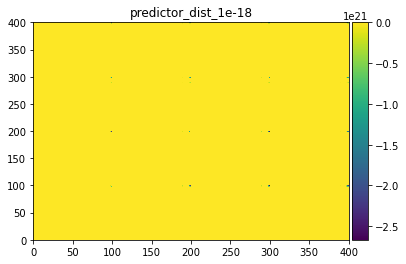

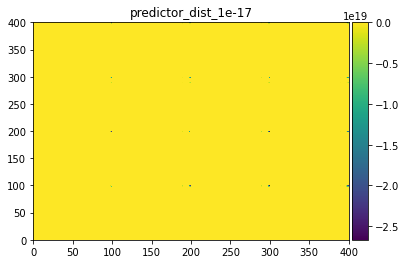

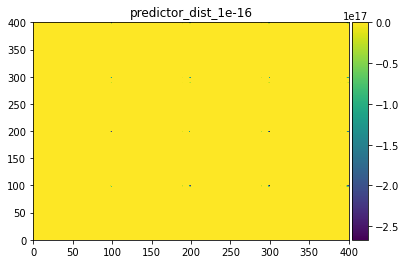

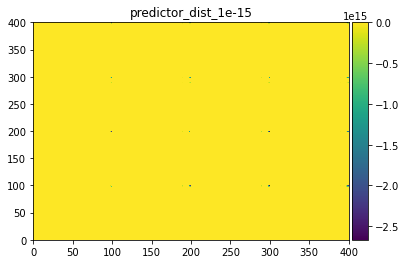

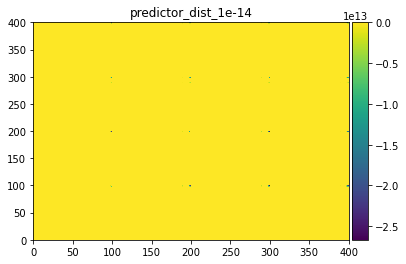

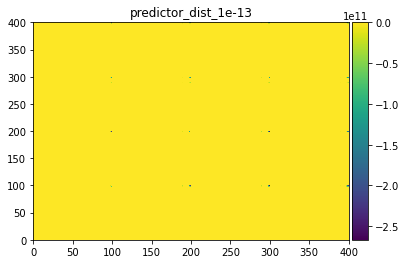

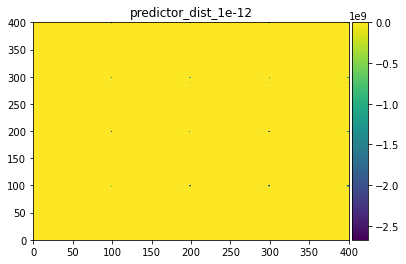

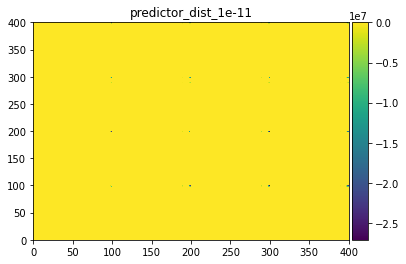

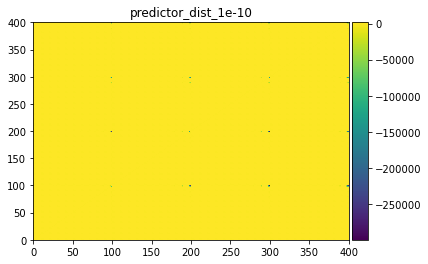

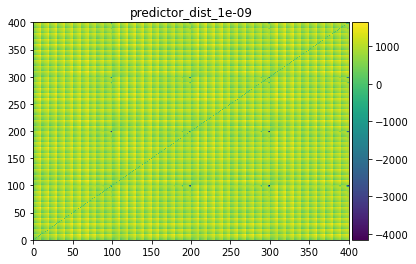

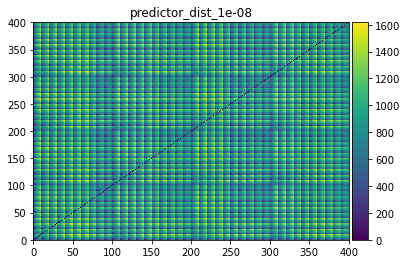

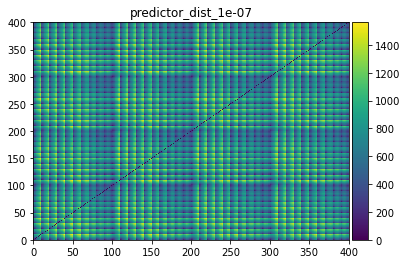

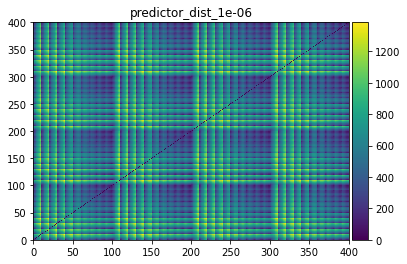

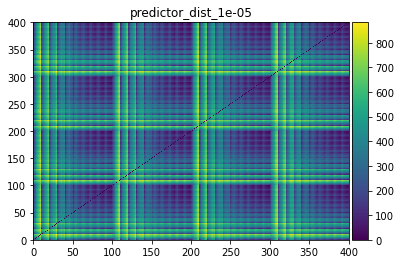

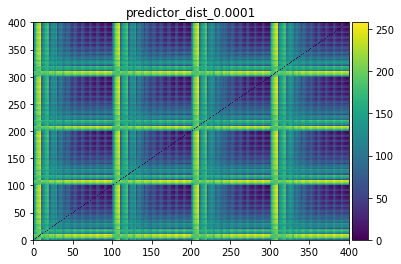

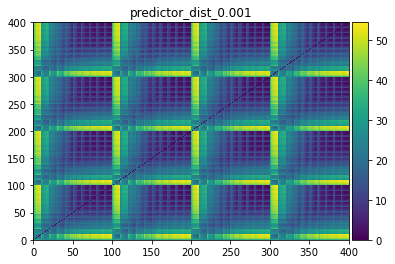

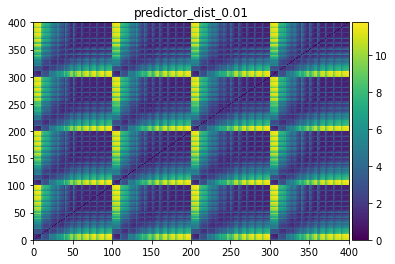

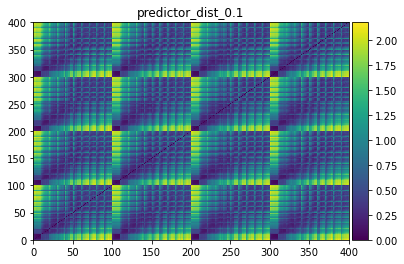

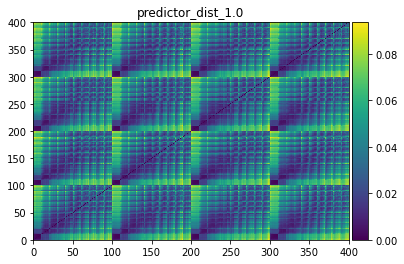

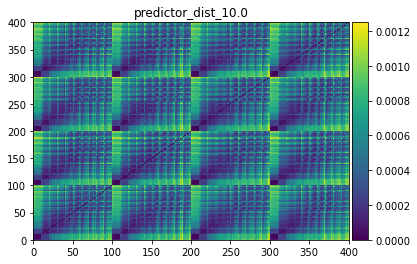

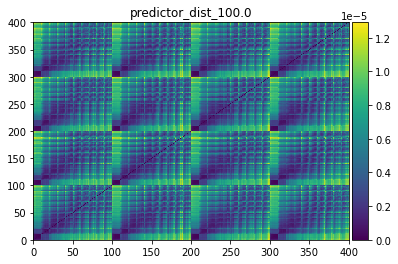

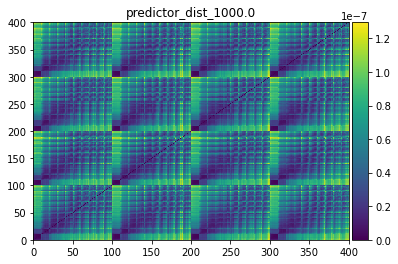

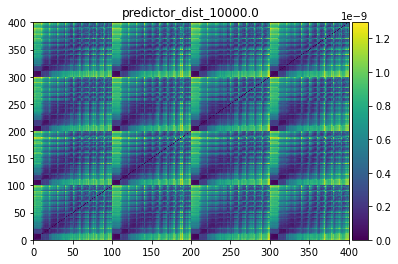

In [16]:
for distname in distnames:
    D = np.load(f'distances/widthdepth/{distname}.npy')
    D = np.reshape(D, [total_models, total_models])
    D = symmetrize(D)
    np.fill_diagonal(D, 0)
    D = D[sorted_inds][:, sorted_inds]
    #D = D[sub_inds][:, sub_inds]

    fig, ax = plt.subplots()
    im = ax.pcolormesh(D)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title(distname)
    plt.show()

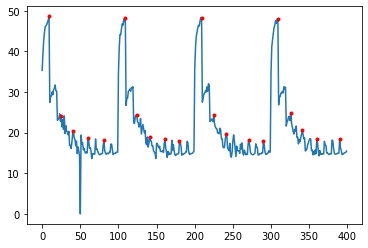

In [17]:
distname = "predictor_dist_0.001"
D = np.load(f'distances/widthdepth/{distname}.npy')
D = np.reshape(D, [total_models, total_models])
D = symmetrize(D)
np.fill_diagonal(D, 0)
D = D[sorted_inds][:, sorted_inds]

from scipy.signal import find_peaks
peaks, _ = find_peaks(D[50, :], distance=15)

plt.plot(np.arange(total_models), D[50, :])
plt.plot(peaks, D[50, peaks], "r.")
plt.show()

In [18]:
model_widths[sorted_inds][peaks]

array([1000,  600,  200,  100,  200, 1000,  500,  200,  200,  100, 1000,
        600,  200,  200,  100, 1000,  700,  200,  100,  100])

In [19]:
def sci_notation(number, sig_fig=2):
    ret_string = "{0:.{1:d}e}".format(number, sig_fig)
    a, b = ret_string.split("e")
    # remove leading "+" and strip leading zeros
    b = str(int(b))
    return "$" + a + "× 10^{" + b + "}$"

In [20]:
distnames

array(['lin_cka_dist', 'lin_cka_prime_dist', 'mean_cca_e2e',
       'mean_sq_cca_e2e', 'procrustes', 'pwcca_dist_e2e',
       'predictor_dist_0.0', 'predictor_dist_1e-20',
       'predictor_dist_1e-19', 'predictor_dist_1e-18',
       'predictor_dist_1e-17', 'predictor_dist_1e-16',
       'predictor_dist_1e-15', 'predictor_dist_1e-14',
       'predictor_dist_1e-13', 'predictor_dist_1e-12',
       'predictor_dist_1e-11', 'predictor_dist_1e-10',
       'predictor_dist_1e-09', 'predictor_dist_1e-08',
       'predictor_dist_1e-07', 'predictor_dist_1e-06',
       'predictor_dist_1e-05', 'predictor_dist_0.0001',
       'predictor_dist_0.001', 'predictor_dist_0.01',
       'predictor_dist_0.1', 'predictor_dist_1.0', 'predictor_dist_10.0',
       'predictor_dist_100.0', 'predictor_dist_1000.0',
       'predictor_dist_10000.0'], dtype='<U22')

In [21]:
depths

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [22]:
chosen_widths = widths[widths > 0]
idx_widths = np.in1d(model_widths, chosen_widths)
sub_widths = model_widths[idx_widths]
sub_num_widths = len(chosen_widths)

chosen_depths = depths[depths > 0]
idx_depths = np.in1d(model_depths, chosen_depths)
sub_depths = model_depths[idx_depths]
sub_num_depths = len(chosen_depths)

sub_idx = idx_widths & idx_depths
sub_inds = np.where(sub_idx)[0]
sub_num_models = np.sum(sub_idx)

In [26]:
num_dists = len(distnames)
D_aves = np.zeros((sub_num_widths*sub_num_depths, sub_num_widths*sub_num_depths, num_dists))
for k in range(num_dists):
    D = np.load(f'distances/widthdepth/{distnames[k]}.npy')
    D = np.reshape(D, [total_models, total_models])
    D = symmetrize(D)
    np.fill_diagonal(D, 0)
    
    D[~sub_idx] = np.nan
    D[:, ~sub_idx] = np.nan
    D = D[sorted_inds][:, sorted_inds]
    D_ave = np.zeros((num_widths*num_depths, num_widths*num_depths))
    for i in range(num_seeds):
        for j in range(num_seeds):
            Dij = D[i*num_widths*num_depths:(i+1)*num_widths*num_depths, j*num_widths*num_depths:(j+1)*num_widths*num_depths]
            D_ave += Dij
    counts = num_seeds**2 * np.ones((num_widths*num_depths, num_widths*num_depths))
    np.fill_diagonal(counts, num_seeds*(num_seeds-1))
    D_ave = D_ave / counts      
    D_ave = D_ave[~np.isnan(D_ave)].reshape((sub_num_widths*sub_num_depths, sub_num_widths*sub_num_depths))
    
    D_aves[:, :, k] = D_ave

In [27]:
embed_type = "MDS"

num_dists = len(distnames)

embeddings = np.zeros((num_dists, sub_num_models, 2))
for i in range(num_dists):
    print(f"Computed {distnames[i]}")
    D = np.load(f'distances/widthdepth/{distnames[i]}.npy')
    D = np.reshape(D, [total_models, total_models])
    D = symmetrize(D)
    np.fill_diagonal(D, 0)
    D = D[sub_inds][:, sub_inds]
    
    if np.any(D < 0):
        embeddings[i, :, :] = np.nan
        print("isnan")
        continue

    if embed_type == "TSNE":
        X_embedded = TSNE(n_components=2, perplexity=20.0, init="random", metric="precomputed").fit_transform(D)
    elif embed_type == "UMAP":
        X_embedded = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.1).fit_transform(np.sqrt(D))
    elif embed_type == "MDS":
        X_embedded = MDS(n_components=2, dissimilarity="precomputed").fit_transform(np.sqrt(D))

    embeddings[i, :, :] = X_embedded

Computed lin_cka_dist
Computed lin_cka_prime_dist
Computed mean_cca_e2e
Computed mean_sq_cca_e2e
isnan
Computed procrustes
Computed pwcca_dist_e2e
isnan
Computed predictor_dist_0.0
isnan
Computed predictor_dist_1e-20
isnan
Computed predictor_dist_1e-19
isnan
Computed predictor_dist_1e-18
isnan
Computed predictor_dist_1e-17
isnan
Computed predictor_dist_1e-16
isnan
Computed predictor_dist_1e-15
isnan
Computed predictor_dist_1e-14
isnan
Computed predictor_dist_1e-13
isnan
Computed predictor_dist_1e-12
isnan
Computed predictor_dist_1e-11
isnan
Computed predictor_dist_1e-10
isnan
Computed predictor_dist_1e-09
isnan
Computed predictor_dist_1e-08
Computed predictor_dist_1e-07
Computed predictor_dist_1e-06
Computed predictor_dist_1e-05
Computed predictor_dist_0.0001
Computed predictor_dist_0.001
Computed predictor_dist_0.01
Computed predictor_dist_0.1
Computed predictor_dist_1.0
Computed predictor_dist_10.0
Computed predictor_dist_100.0
Computed predictor_dist_1000.0
Computed predictor_dist_1

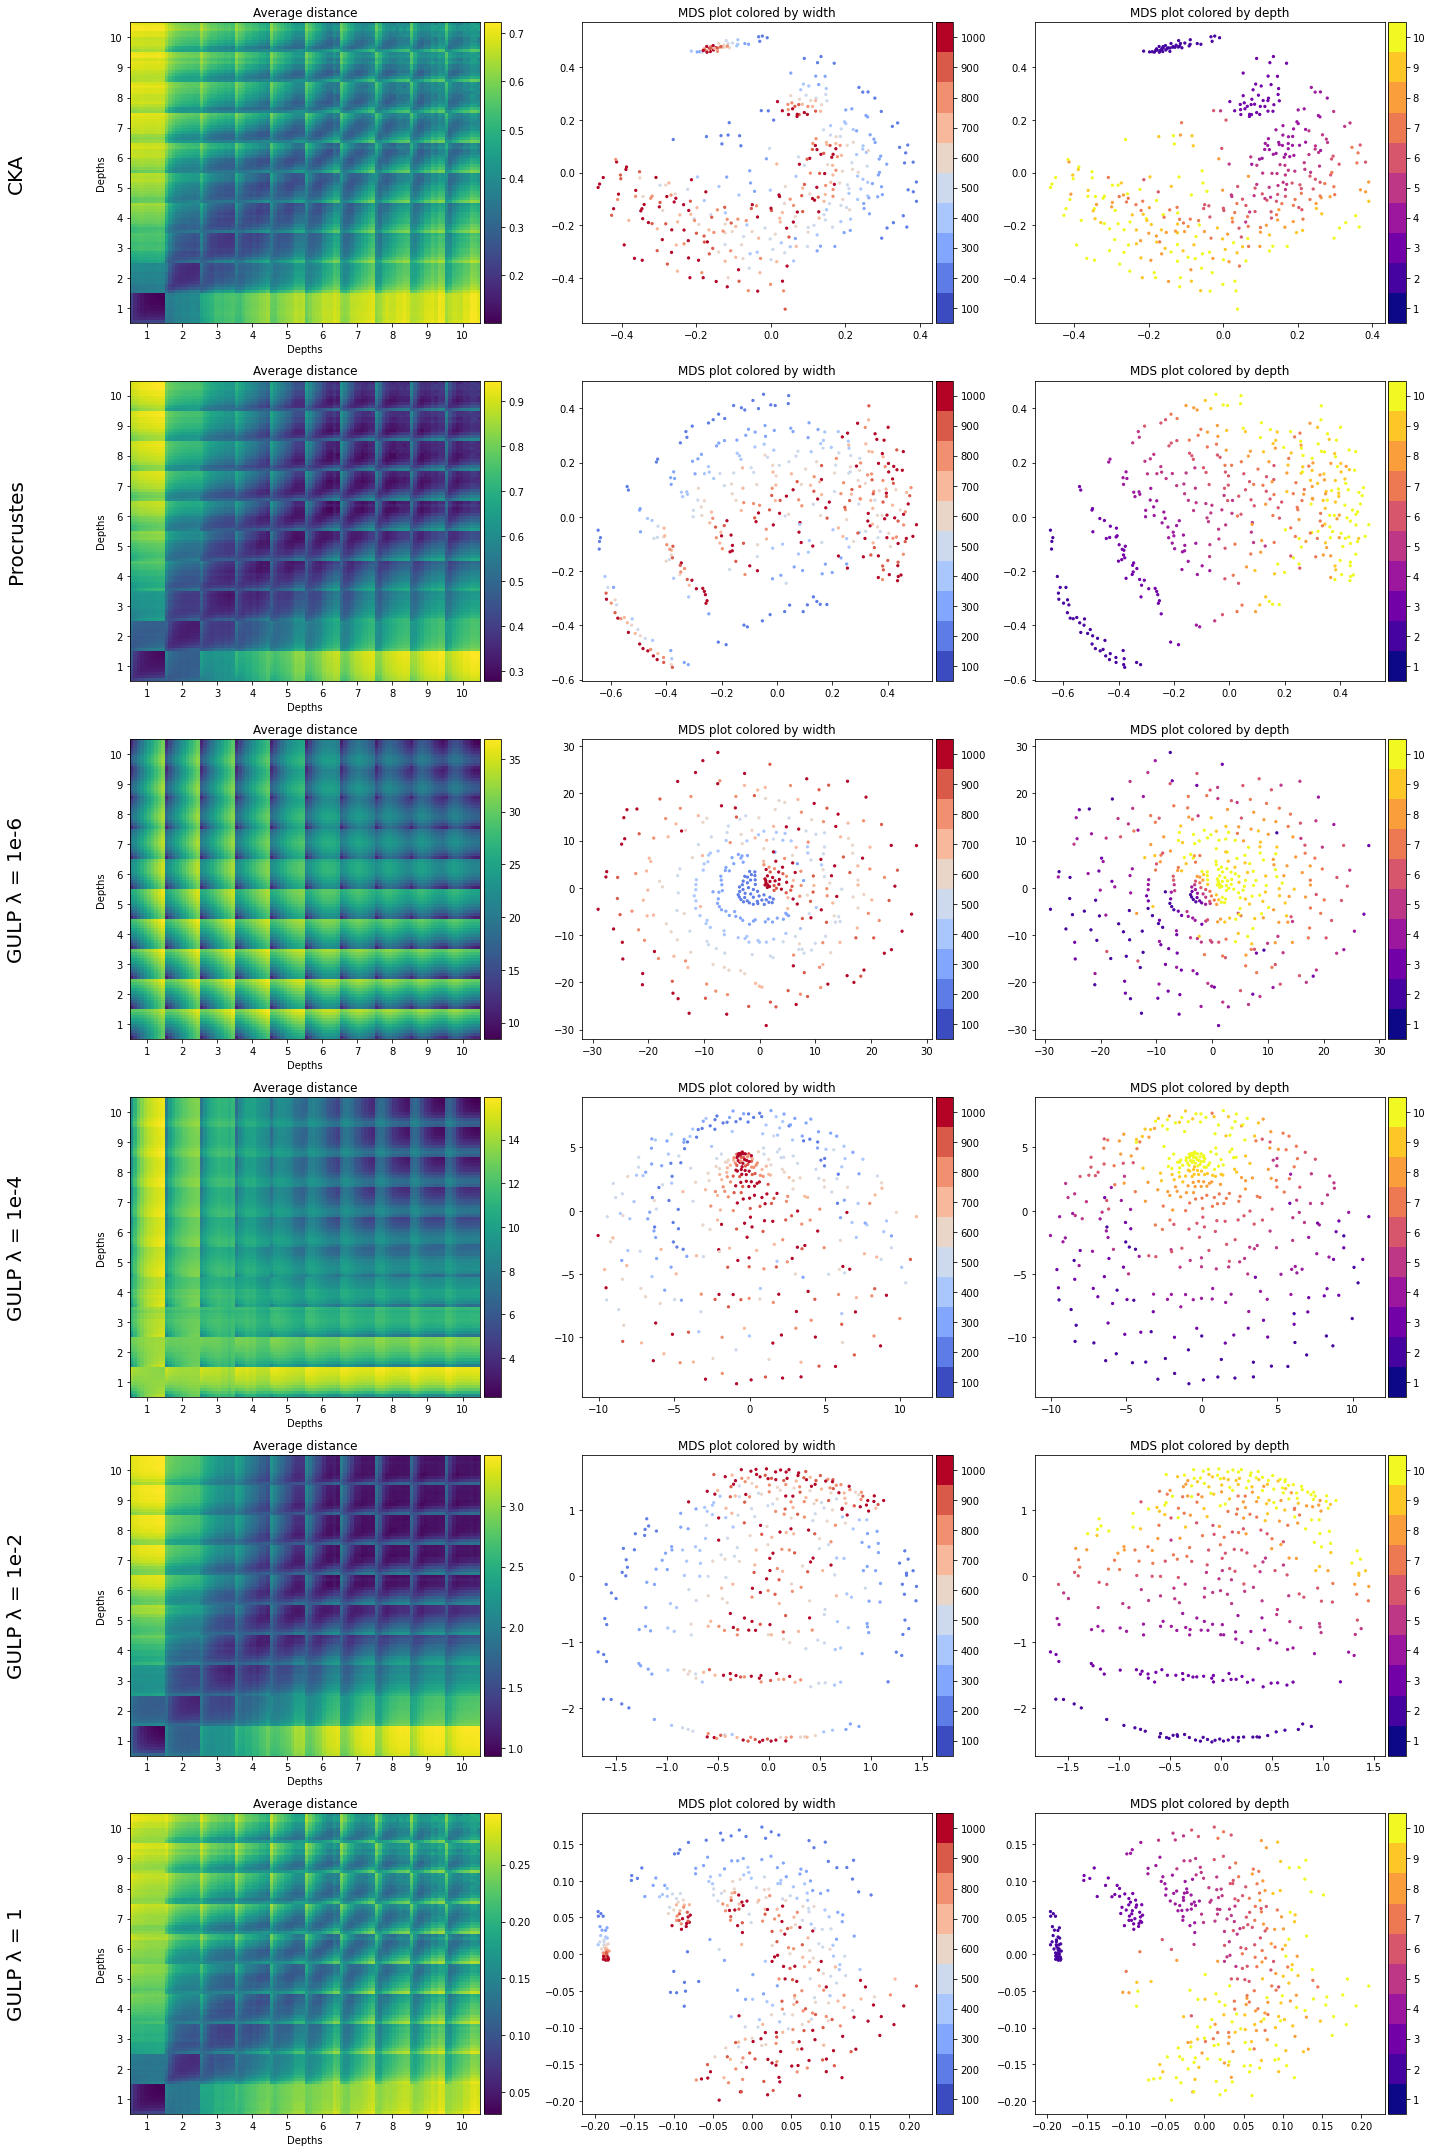

In [30]:
dist_inds = [0, 4, 21, 23, 25, 27]

labels = ['CKA', 'Procrustes', 'GULP λ = 1e-6', 'GULP λ = 1e-4', 'GULP λ = 1e-2', 'GULP λ = 1']
#labels = distnames[dist_inds]

cmap_width = cm.get_cmap("coolwarm")
cmaplist_width = [cmap_width(i) for i in range(cmap_width.N)]
cmap_width = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist_width, cmap_width.N)
norm_width = mpl.colors.BoundaryNorm(np.arange(len(chosen_widths)+1), cmap_width.N)

cmap_depth = cm.get_cmap("plasma")
cmaplist_depth = [cmap_depth(i) for i in range(cmap_depth.N)]
cmap_depth = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist_depth, cmap_depth.N)
norm_depth = mpl.colors.BoundaryNorm(np.arange(len(chosen_depths)+1), cmap_depth.N)

fig, axs = plt.subplots(len(dist_inds), 4, figsize=(20, 30), gridspec_kw={'width_ratios': [1, 20, 20, 20]})
for i in range(len(dist_inds)):
    ax = axs[i, 0]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_ylabel(labels[i], fontsize=20)
    
    ax = axs[i, 1]
    im = ax.pcolormesh(np.sqrt(D_aves[:, :, dist_inds[i]]))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title(f"Average distance")
    ax.set_yticks(np.linspace(sub_num_widths/2, sub_num_widths*(sub_num_depths-1/2), sub_num_depths))
    ax.set_yticklabels(chosen_depths)
    ax.set_ylabel("Depths")
    ax.set_xticks(np.linspace(sub_num_widths/2, sub_num_widths*(sub_num_depths-1/2), sub_num_depths))
    ax.set_xticklabels(chosen_depths)
    ax.set_xlabel("Depths")
    
    X_embedded = embeddings[dist_inds[i], :, :]

    ax = axs[i, 2]
    sc = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=model_widths[sub_inds]/100, s=5, cmap=cmap_width, norm=norm_width)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(sc, cax=cax, orientation='vertical', ticks=mpl.ticker.FixedLocator(np.arange(len(chosen_widths))+0.5))
    cbar.ax.set_yticklabels(chosen_widths)
    ax.set_title(f'{embed_type} plot colored by width')
    
    ax = axs[i, 3]
    sc = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=model_depths[sub_inds], s=5, cmap=cmap_depth, norm=norm_depth)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(sc, cax=cax, orientation='vertical', ticks=mpl.ticker.FixedLocator(np.arange(len(chosen_depths))+0.5))
    cbar.ax.set_yticklabels(chosen_depths)
    ax.set_title(f'{embed_type} plot colored by depth')
fig.tight_layout()
plt.savefig("/home/gridsan/gstepaniants/geometric_toolkit_shared/paper_figures/mnist_width_depth.pdf")
plt.show()

In [ ]:
dist_inds = [0, 4, 21, 25, 27]

labels = ['CKA', 'Procrustes', 'GULP λ = 1e-6', 'GULP λ = 1e-2', 'GULP λ = 1']
#labels = distnames[dist_inds]

cmap_width = cm.get_cmap("coolwarm")
cmaplist_width = [cmap_width(i) for i in range(cmap_width.N)]
cmap_width = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist_width, cmap_width.N)
norm_width = mpl.colors.BoundaryNorm(np.arange(len(chosen_widths)+1), cmap_width.N)

cmap_depth = cm.get_cmap("plasma")
cmaplist_depth = [cmap_depth(i) for i in range(cmap_depth.N)]
cmap_depth = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist_depth, cmap_depth.N)
norm_depth = mpl.colors.BoundaryNorm(np.arange(len(chosen_depths)+1), cmap_depth.N)

fig, axs = plt.subplots(3, len(dist_inds), figsize=(24, 8), gridspec_kw={'height_ratios': [1, 20, 20]})
for i in range(len(dist_inds)):
    ax = axs[0, i]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(labels[i], fontsize=25)
    
    X_embedded = embeddings[dist_inds[i], :, :]

    ax = axs[1, i]
    sc = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=model_widths[sub_inds]/100, s=5, cmap=cmap_width, norm=norm_width)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(sc, cax=cax, orientation='vertical', ticks=mpl.ticker.FixedLocator(np.arange(len(chosen_widths))+0.5))
    cbar.ax.set_yticklabels(chosen_widths)
    ax.set_title(f'{embed_type} plot colored by width')
    
    ax = axs[2, i]
    sc = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=model_depths[sub_inds], s=5, cmap=cmap_depth, norm=norm_depth)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(sc, cax=cax, orientation='vertical', ticks=mpl.ticker.FixedLocator(np.arange(len(chosen_depths))+0.5))
    cbar.ax.set_yticklabels(chosen_depths)
    ax.set_title(f'{embed_type} plot colored by depth')
fig.tight_layout()
plt.savefig("/home/gridsan/gstepaniants/geometric_toolkit_shared/paper_figures/mnist_width_depth_small.pdf", bbox_inches='tight')
plt.show()